In [11]:
#stock network import
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torchsummary
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# genetic
# !pip install deap
from deap import creator, base, tools, algorithms
import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
import heapq

import multiprocessing
from concurrent.futures import ProcessPoolExecutor







In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to the range [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 256, shuffle = False, num_workers = 2) # v100 gpy says 2 workers
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False, num_workers = 2)

classes = trainset.classes
num_classes = len(classes)
print("Classes in CIFAR-10 dataset:", classes)

#deifne GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_images = []
train_labels = []
test_images = []
test_labels = []

for data in trainloader:
  train_images.append(data[0].to(device))
  train_labels.append(data[1].to(device))

for data in testloader:
  test_images.append(data[0].to(device))
  test_labels.append(data[1].to(device))



Files already downloaded and verified
Files already downloaded and verified
Classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda


In [13]:
class my_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(my_CNN, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional Blocks
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

model = my_CNN()

model = model.to(device=device)
print(model)
torchsummary.summary(model, (3,32,32))
model.load_state_dict(torch.load("new_CNN_notebook.pth", map_location=device))

multiprocessing.set_start_method('spawn', True)
loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0015, weight_decay = 0.00001)

print("Model device:", next(model.parameters()).device)

my_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(64, 128, kern

In [15]:
def all_acc():
    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()

    with torch.no_grad():
        for i in range(len(test_images)):
            #images, labels = data[0].to(device), data[1].to(device)
            outputs = model(test_images[i])
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels[i].size(0)
            correct += (predicted == test_labels[i]).sum().item()
            #print(loss_func(outputs,train_labels[i]).item())
            for label, prediction in zip(test_labels[i], predicted):
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1
                total_pred[classes[label.item()]] += 1
    model.train()

    print('Accuracy of the network on the 10 000 test images: %f %%' % (100 * correct / total))

    for classname, correct_count in correct_pred.items():
        accuracy = 100* float(correct_count)/ total_pred[classname]
        print(f'Accuracy for: {classname:5s} is {accuracy:0.1f} %')
    return 100*(correct/total)

def all_acc_test():
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i in range(len(test_images)):
        #images, labels = data[0].to(device), data[1].to(device)
          outputs = model(test_images[i])
          _, predicted = torch.max(outputs.data, 1)
          total += test_labels[i].size(0)
          correct += (predicted == test_labels[i]).sum().item()
    model.train()
    return 100*(correct/total)

all_acc()

def show_stats(loss_values, mean_fits, best_ind):
    post_training_acc = all_acc_test()
    plt.plot(np.array(loss_values), 'r')
    plt.title('Loss Values Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(np.array(mean_fits), 'b')
    plt.title('Mean Fitness Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Fitness')
    plt.show()

    print("Fitness %s" % (calc_fitness(best_ind)))
    print(f'post training/best individual = {post_training_acc}')
    print()

    all_labels = []
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for data in range(len(test_images)):
            outputs = model(test_images[data])
            _, predicted = torch.max(outputs.data, 1)
            all_labels.append(test_labels[data].cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())


    # Concatenate all batches
    all_labels = np.concatenate(all_labels)
    all_predictions = np.concatenate(all_predictions)

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    # Print metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



Accuracy of the network on the 10 000 test images: 84.080000 %
Accuracy for: airplane is 80.5 %
Accuracy for: automobile is 92.0 %
Accuracy for: bird  is 71.3 %
Accuracy for: cat   is 68.3 %
Accuracy for: deer  is 87.5 %
Accuracy for: dog   is 78.3 %
Accuracy for: frog  is 90.6 %
Accuracy for: horse is 87.1 %
Accuracy for: ship  is 91.8 %
Accuracy for: truck is 93.4 %


In [50]:
# VARIABLES
pop_size = 80 # try make this divisibale by 10 and 2 for n_elitest and n_replace
epoch = 200

bits_per_chrom = 30
n_in = 128
n_out = 10
chrom_length = (n_in+1) * n_out 
num_of_bits = chrom_length*bits_per_chrom
dspInterval = 50
n_elitest = int(pop_size/10)
n_replace = int(pop_size/2) #pop_size/5

min_value = -1.0
max_value = 1.0

cross_prob = .8
mutate_prob = .95
flip_prob = 1. / (chrom_length * (bits_per_chrom/30))

loss_values = []
mean_fits = []

def chrom_to_real(genotype):
    indas_string = ''.join(map(str,genotype))
    degray = gray_to_bin(indas_string)
    num_as_int = int(degray, 2)
    num_in_range =  min_value + ((max_value*2)*(num_as_int / 2**bits_per_chrom))
    return num_in_range 

def real_to_chrom(phenotype):
    weight = phenotype/20
    if weight < -1:
        weight = -1
    if weight > 1:
        weight = 1

    int_part = int(2**bits_per_chrom * ((weight+1)/2))
    if int_part == 2**bits_per_chrom:
        int_part -= 1
    chrom = [int(d) for d in str(bin(int_part))[2:]]
    while(len(chrom) < bits_per_chrom):
        chrom.insert(0,0)
    indas_string = ''.join(map(str,chrom))
    chrom = bin_to_gray(indas_string)
    out = []
    for digit in chrom:
        out.append(int(digit))
    return out

def extract_weights(individual):
    weights = []
    for i in range(0, num_of_bits, bits_per_chrom):
        weights.append(chrom_to_real(individual[i:i+bits_per_chrom]))#

    return weights

def calc_fitness(individual):
    weights = extract_weights(individual)
    weights = np.asarray(weights)

    model.fc2.weight = nn.Parameter(torch.from_numpy(weights[:chrom_length-10].reshape(128,10).T).to(torch.float32))
    model.fc2.bias = nn.Parameter(torch.from_numpy(weights[chrom_length-10:]).to(torch.float32))

    for param in model.fc2.parameters():
        param.data = param.data.to(device=device)

    total = 0
    running_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(len(train_images)):
            out = model(train_images[i])
            total += 1
            loss = loss_func(out, train_labels[i])
            running_loss += loss.item()
    return running_loss/total

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register('attr_bool', random.randint, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, num_of_bits) # Individual
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", calc_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=flip_prob)
toolbox.register("select", tools.selTournament, fit_attr='fitness')



/user/HS400/ye00098/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/user/HS400/ye00098/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [48]:
for param in model.parameters():
    param.requires_grad = False

#unfreeze fuly connected layer
for param in model.fc2.parameters():
    param.requires_grad = True

#randomize the wights  the below is pointless
print(model.fc2.weight.dtype, model.fc2.weight.shape)
print(model.fc2.bias.dtype,  model.fc2.bias.shape)
model.fc2.reset_parameters()
print("Model device:", next(model.parameters()).device)


pre_training_acc = all_acc()


torch.float32 torch.Size([10, 128])
torch.float32 torch.Size([10])
Model device: cuda:0
Accuracy of the network on the 10 000 test images: 11.360000 %
Accuracy for: airplane is 0.0 %
Accuracy for: automobile is 5.6 %
Accuracy for: bird  is 0.1 %
Accuracy for: cat   is 0.9 %
Accuracy for: deer  is 11.9 %
Accuracy for: dog   is 1.8 %
Accuracy for: frog  is 17.8 %
Accuracy for: horse is 63.1 %
Accuracy for: ship  is 0.0 %
Accuracy for: truck is 12.4 %


  Evaluated 80 individuals
-- Generation 0 / 200--


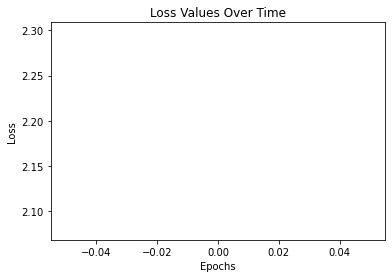

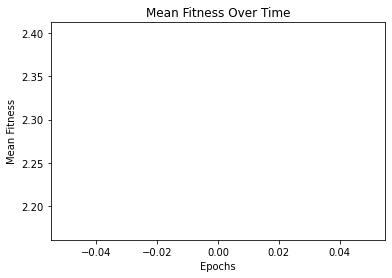

Fitness 2.188500382462326
post training/best individual = 10.0

Precision: 0.1318
Recall: 0.1685
F1 Score: 0.1349


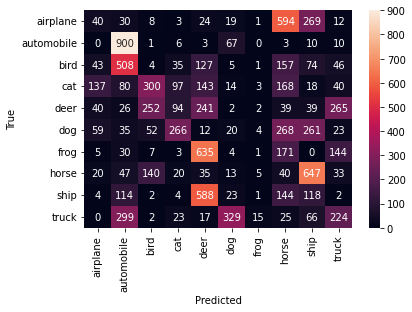

-- Generation 1 / 200--
-- Generation 2 / 200--
-- Generation 3 / 200--
-- Generation 4 / 200--
-- Generation 5 / 200--
-- Generation 6 / 200--
-- Generation 7 / 200--
-- Generation 8 / 200--
-- Generation 9 / 200--
-- Generation 10 / 200--
-- Generation 11 / 200--
-- Generation 12 / 200--
-- Generation 13 / 200--
-- Generation 14 / 200--
-- Generation 15 / 200--
-- Generation 16 / 200--
-- Generation 17 / 200--
-- Generation 18 / 200--
-- Generation 19 / 200--
-- Generation 20 / 200--
-- Generation 21 / 200--
-- Generation 22 / 200--
-- Generation 23 / 200--
-- Generation 24 / 200--
-- Generation 25 / 200--
-- Generation 26 / 200--
-- Generation 27 / 200--
-- Generation 28 / 200--
-- Generation 29 / 200--
-- Generation 30 / 200--
-- Generation 31 / 200--
-- Generation 32 / 200--
-- Generation 33 / 200--
-- Generation 34 / 200--
-- Generation 35 / 200--
-- Generation 36 / 200--
-- Generation 37 / 200--
-- Generation 38 / 200--
-- Generation 39 / 200--
-- Generation 40 / 200--
-- Genera

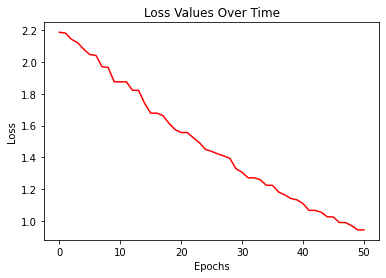

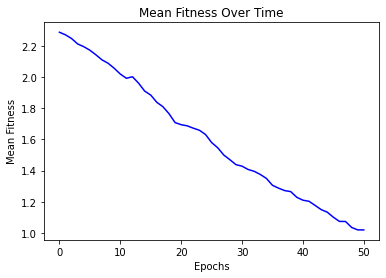

Fitness 0.9428073161718796
post training/best individual = 10.0

Precision: 0.6805
Recall: 0.6442
F1 Score: 0.6202


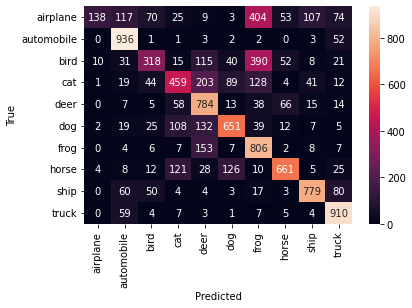

-- Generation 51 / 200--
-- Generation 52 / 200--
-- Generation 53 / 200--
-- Generation 54 / 200--
-- Generation 55 / 200--
-- Generation 56 / 200--
-- Generation 57 / 200--
-- Generation 58 / 200--
-- Generation 59 / 200--
-- Generation 60 / 200--
-- Generation 61 / 200--
-- Generation 62 / 200--
-- Generation 63 / 200--
-- Generation 64 / 200--
-- Generation 65 / 200--
-- Generation 66 / 200--
-- Generation 67 / 200--
-- Generation 68 / 200--
-- Generation 69 / 200--
-- Generation 70 / 200--
-- Generation 71 / 200--
-- Generation 72 / 200--
-- Generation 73 / 200--
-- Generation 74 / 200--
-- Generation 75 / 200--
-- Generation 76 / 200--
-- Generation 77 / 200--
-- Generation 78 / 200--
-- Generation 79 / 200--
-- Generation 80 / 200--
-- Generation 81 / 200--
-- Generation 82 / 200--
-- Generation 83 / 200--
-- Generation 84 / 200--
-- Generation 85 / 200--
-- Generation 86 / 200--
-- Generation 87 / 200--
-- Generation 88 / 200--
-- Generation 89 / 200--
-- Generation 90 / 200--


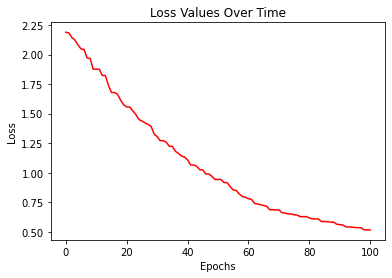

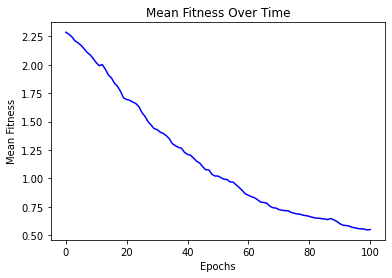

Fitness 0.5161011929110605
post training/best individual = 10.0

Precision: 0.7756
Recall: 0.7733
F1 Score: 0.7711


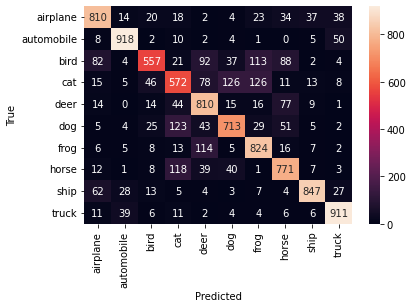

-- Generation 101 / 200--
-- Generation 102 / 200--
-- Generation 103 / 200--
-- Generation 104 / 200--
-- Generation 105 / 200--
-- Generation 106 / 200--
-- Generation 107 / 200--
-- Generation 108 / 200--
-- Generation 109 / 200--
-- Generation 110 / 200--
-- Generation 111 / 200--
-- Generation 112 / 200--
-- Generation 113 / 200--
-- Generation 114 / 200--
-- Generation 115 / 200--
-- Generation 116 / 200--
-- Generation 117 / 200--
-- Generation 118 / 200--
-- Generation 119 / 200--
-- Generation 120 / 200--
-- Generation 121 / 200--
-- Generation 122 / 200--
-- Generation 123 / 200--
-- Generation 124 / 200--
-- Generation 125 / 200--
-- Generation 126 / 200--
-- Generation 127 / 200--
-- Generation 128 / 200--
-- Generation 129 / 200--
-- Generation 130 / 200--
-- Generation 131 / 200--
-- Generation 132 / 200--
-- Generation 133 / 200--
-- Generation 134 / 200--
-- Generation 135 / 200--
-- Generation 136 / 200--
-- Generation 137 / 200--
-- Generation 138 / 200--
-- Generatio

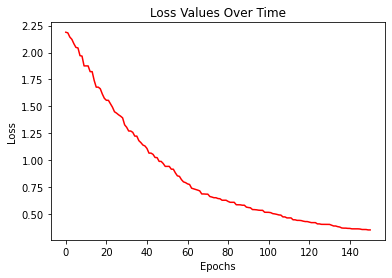

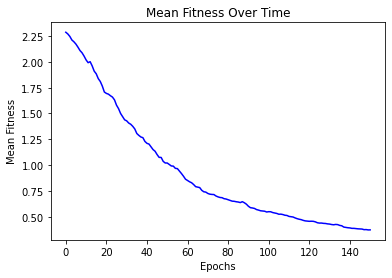

Fitness 0.3528424788798605
post training/best individual = 10.0

Precision: 0.8131
Recall: 0.8110
F1 Score: 0.8114


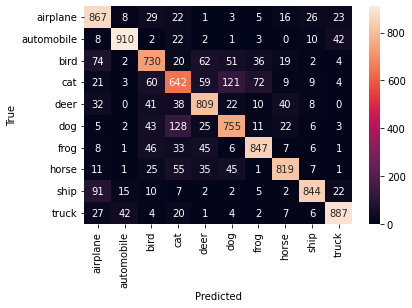

-- Generation 151 / 200--
-- Generation 152 / 200--
-- Generation 153 / 200--
-- Generation 154 / 200--
-- Generation 155 / 200--
-- Generation 156 / 200--
-- Generation 157 / 200--
-- Generation 158 / 200--
-- Generation 159 / 200--
-- Generation 160 / 200--
-- Generation 161 / 200--
-- Generation 162 / 200--
-- Generation 163 / 200--
-- Generation 164 / 200--
-- Generation 165 / 200--
-- Generation 166 / 200--
-- Generation 167 / 200--
-- Generation 168 / 200--
-- Generation 169 / 200--
-- Generation 170 / 200--
-- Generation 171 / 200--
-- Generation 172 / 200--
-- Generation 173 / 200--
-- Generation 174 / 200--
-- Generation 175 / 200--
-- Generation 176 / 200--
-- Generation 177 / 200--
-- Generation 178 / 200--
-- Generation 179 / 200--
-- Generation 180 / 200--
-- Generation 181 / 200--
-- Generation 182 / 200--
-- Generation 183 / 200--
-- Generation 184 / 200--
-- Generation 185 / 200--
-- Generation 186 / 200--
-- Generation 187 / 200--
-- Generation 188 / 200--
-- Generatio

In [51]:
#def main():
popa = toolbox.population(n=pop_size)
#scale weights down
pop=[]
for ind in popa:
    sep=extract_weights(ind)
    weightlist=[]
    for weight in sep:
        weightlist+=real_to_chrom(weight)#/20)
    #print(weightlist)
    pop.append(creator.Individual(weightlist))


# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = (fit,)
print("  Evaluated %i individuals" % len(pop))

g = 0
loss_values = []
mean_fits = []
# Begin the evolution

while g < epoch:
    # A new generation
    if g == 100:
        mutate_prob = 1
        cross_prob = 1
    print("-- Generation %i / %i--" % (g, epoch))

    # Select the next generation individuals from my understanding, best 5 of population get picked, then to fill the rest of next gen its randomly chosen out of all of population (which includes those best 5)
    offspring = tools.selBest(pop, n_elitest)
    offspring += toolbox.select(pop,len(pop)-n_elitest,2)
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    for child1, child2 in zip(offspring[4::2], offspring[5::2]):

        # cross two individuals with probability CXPB
        if random.random() < cross_prob:
            #print('before crossover ',child1, child2)
            toolbox.mate(child1, child2)
            #print('after crossover ',child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring[4::]:

        # mutate an individual with probability mutateprob
        if random.random() < mutate_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values


########################################################################
#                  LOCAL SEARCH                                        #
########################################################################

    for individual in offspring:
        weights=extract_weights(individual)
        weights = np.asarray(weights)
        model.fc2.weight = nn.Parameter(torch.from_numpy(weights[:chrom_length-10].reshape(128,10).T).to(torch.float32))
        model.fc2.bias = nn.parameter.Parameter(torch.from_numpy(weights[chrom_length-10:]).to(torch.float32))

        for param in model.fc2.parameters():
            param.data = param.data.to(device=device)

        out = model.fc2.weight.reshape(1280).tolist()
        out_bias = model.fc2.bias.reshape(10).tolist()

        weights = out + out_bias

        individual.clear()

        newInd=[]
        for index in range(len(weights)):
            chromosome = real_to_chrom(weights[index])
            newInd += chromosome
        newInd = creator.Individual(newInd)

        offspring.remove(individual)
        offspring.append(newInd)

    fitnesses = list(map(toolbox.evaluate, offspring))

    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit,)


    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    indices_lowest = heapq.nsmallest(n_replace, range(len(fits)), key=lambda k: fits[k])
    indices_largest = heapq.nlargest(n_replace, range(len(fits)), key=lambda k: fits[k])

    for i in range(n_replace):
        pop[indices_largest[i]] = pop[indices_lowest[i]]


    fits = [ind.fitness.values[0] for ind in pop]
    loss_values.append(min(fits))

    # The population is entirely replaced by the offspring

    length = len(pop)
    mean = sum(fits) / length
    mean_fits.append(mean)
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5


    if g%dspInterval == 0:
        #Gather all the fitnesses in one list and print the stats
        best_ind = tools.selBest(pop, 1)[0]
        show_stats(loss_values, mean_fits, best_ind)


    # print("  Min %s" % min(fits))
    # print("  Max %s" % max(fits))
    # print("  Avg %s" % mean)
    # print("  Std %s" % std)
    g += 1

print("-- End of (successful) evolution --")

#global best_ind
best_ind = tools.selBest(pop, 1)[0]
print("Fitness %s" % (calc_fitness(best_ind)))




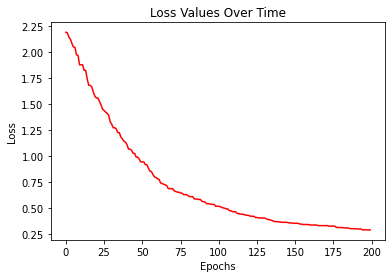

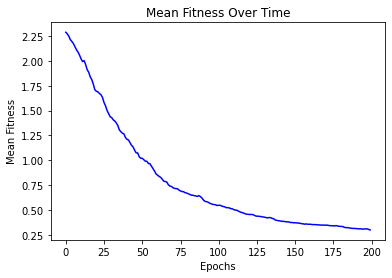

Fitness 0.2894115905676569
post training/best individual = 81.91000000000001

Precision: 0.8190
Recall: 0.8191
F1 Score: 0.8186


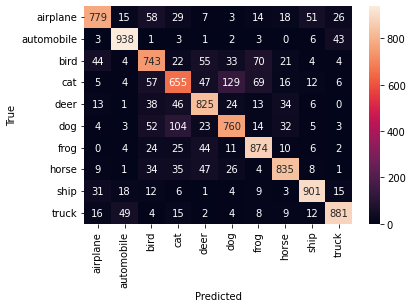

In [53]:
show_stats(loss_values, mean_fits, best_ind)


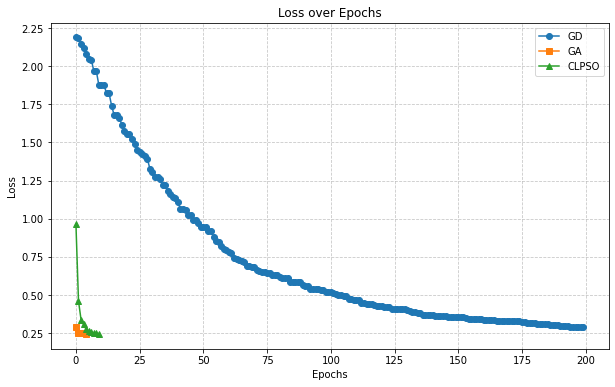

In [55]:
#epochs = range(1, 55)  # Replace 11 with the number of epochs you have
#loss_line1 = [0.2, 0.15, 0.1, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
loss_clpso = [1.9258, 0.9215, 0.6772, 0.6141, 0.5479, 0.5248, 0.5190, 0.4985, 0.4966, 0.4929]
loss_gradient = [0.5827, 0.5065, 0.4993, 0.4946, 0.4882]
counter =0
for i in loss_gradient:
    loss_gradient[counter] = i/2
    counter +=1
counter = 0
for  i in loss_clpso:
    loss_clpso[counter] = i/2
    counter += 1
# Plotting the lines
plt.figure(figsize=(10, 6))

plt.plot(loss_values, label='GA', marker='o')
plt.plot(loss_gradient, label='GD', marker='s')
plt.plot(loss_clpso, label='CLPSO', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True, linestyle='--', alpha=0.7)
# Adding legend
plt.legend()

# Display the plot
plt.show()